In [5]:
import numpy as np
import matplotlib.pyplot as plt


def p(x, mu, sigma):
    """Normal distribution probability density function"""
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)

def p_S(x, mu_s=2, sigma_s=3):
    """ S ~ N(mu_s, sigma_s) = p_S(x) """
    return p(x, mu_s, sigma_s)
def p_B(x, mu_b=10, sigma_b=5):
    """ B ~ N(mu_b, sigma_b) = p_B(x) """
    return p(x, mu_b, sigma_b)

def p_M(x, f):
    """
    Define probability density function of mixture
    model of S and B with class proportion f
    """
    assert 0 <= f <= 1
    return f * p_S(x) + (1 - f) * p_B(x)

Sampling from this distribution is annoying, so we'll take advantage of numpy's `random.normal` sampling function and use rejection sampling to get the distribution we want.

In [6]:

# signal and background distributions, taken from the CWoLA paper
mu_s, sigma_s = 5, 10
mu_b, sigma_b = 5, 5

rng = np.random.default_rng(42)

def rejection_sample(f, N):
    """ generate N samples from the mixture model using rejection sampling 
    
    output:
        array of shape (N, 3) with columns [x, is_background, is_signal]. 
        note that is_signal = 1 - is_background. this is not strictly necessary
        but the loss function we are using requires this format.
    """
    assert 0 <= f <= 1
    samples = []
    while len(samples) < N:
        if np.random.rand() < f:
            samples.append([rng.normal(mu_s, sigma_s), 0, 1])
        else:
            samples.append([rng.normal(mu_b, sigma_b), 1, 0])
    return np.array(samples)

In [7]:
# signal fractions
f_1 = 0.2
f_2 = 1 - f_1

# mixture samples
M1 = rejection_sample(f_1, 100000)
M2 = rejection_sample(f_2, 100000)
print('M1 % signal:', round(100*np.mean(M1[:,2]), 1))
print('M2 % signal:', round(100*np.mean(M2[:,2]), 1))

# labels for the CWoLA problem. we treat M1 and M2 as distinct classes
M1_new = np.copy(M1)
M1_new[:,[1,2]] = [1,0]
M2_new = np.copy(M2)
M2_new[:,[1,2]] = [0,1]
M1M2 = np.concatenate([M1_new, M2_new], axis=0)

print('M1M2 % M2 (signal-rich):', round(100*np.mean(M1M2[:,2]), 1))
print('M1M2 % M1 (signal-poor):', round(100*np.mean(M1M2[:,2]), 1))

M1 % signal: 20.0
M2 % signal: 80.1
M1M2 % M2 (signal-rich): 50.0
M1M2 % M1 (signal-poor): 50.0


In [43]:
# classifier 
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

class DNNClassifier(nn.Module):
    def __init__(self, hidden_layers=3, in_features=1, hidden_features=30, out_features=2, act='GELU', 
                 softmax=False, sigmoid=False, dropout=False):
        super(DNNClassifier, self).__init__()
        if hidden_layers < 2:
            raise ValueError("hidden_layers must be >= 2")
        if act is None:
            act = nn.GELU()
        else:
            act = getattr(nn, act)()

        self.net = []
        
        if dropout:
            self.dropout = nn.Dropout(dropout if isinstance(dropout, float) else 0.1)

        # input layer
        self.net.append(nn.Linear(in_features, hidden_features))
        self.net.append(act)
        if dropout: self.net.append(self.dropout)
        
        # hidden layers
        for _ in range(hidden_layers-2):
            self.net.append(nn.Linear(hidden_features, hidden_features))
            self.net.append(act)
            if dropout: self.net.append(self.dropout)

        self.net.append(nn.Linear(hidden_features, out_features))
        if softmax:
            self.net.append(nn.Softmax(dim=1))
        if sigmoid:
            self.net.append(nn.Sigmoid())
            
        self.net = nn.Sequential(*self.net)
        
        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight, gain=2)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)
    
class GaussianDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.x = torch.tensor(data[:, 0], dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(data[:, 1:], dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        out = {}
        out['x'] = self.x[idx]
        out['y'] = self.y[idx]
        return out


def test_classifier(classifier, dset):
    classifier.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for batch in dset:
            inputs = batch['x'].to(device)
            labels = batch['y'].to(device)
            output = classifier(inputs)
            _, predicted = torch.max(torch.sigmoid(output.data), 1)
            
            total += labels.size(0)
            accuracy += (predicted == labels[:,1]).sum().item()
    return accuracy / total * 100

def train_classifier(data, batch_size=2048, epochs=100, notify_every=10, lr=0.001, tqdm=tqdm, reduce_lr=False,
                     dropout=False):
    if tqdm is False: tqdm = lambda x,**kwargs:x

    classifier = DNNClassifier(hidden_layers=3, hidden_features=32, dropout=dropout).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    dset = GaussianDataset(data)
    if reduce_lr:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    val_split = 0.1
    train,val = random_split(dset, [1-val_split, val_split])
    dataloader = {
        "train": DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True),
        "val": DataLoader(val, batch_size=batch_size, shuffle=True, pin_memory=True)
    }
    max_acc = 0.0
    accuracies = []
    losses = []
    for epoch in tqdm(range(epochs), total=epochs, leave=False):
        running_loss = []
        for i, batch in enumerate(dataloader['train']):
            optimizer.zero_grad()        
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            output = classifier(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += [loss.item()]
            accuracy = test_classifier(classifier, dataloader['val'])
            accuracies.append(accuracy)
            losses.append(loss.item())

        if reduce_lr:
            scheduler.step(losses[-1])

        if accuracy > max_acc:
            max_acc = accuracy
        if notify_every>0 and (epoch+1) % notify_every == 0:
            print(f'[{epoch+1:>3}] max acc: {max_acc:.1f}%, test acc: {accuracy:.1f}%, loss: {np.mean(running_loss):.3f}')
    return classifier, accuracies, losses

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" \
                                if torch.backends.mps.is_available() else "cpu")
device = torch.device('mps')
device

device(type='mps')

In [44]:
clf, acc, loss = train_classifier(M1M2, batch_size=2048, epochs=10, notify_every=1, lr=0.0005, reduce_lr=False,
                                  dropout=False)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:07<01:10,  7.87s/it]

[  1] max acc: 51.8%, test acc: 51.8%, loss: 2.340


 20%|██        | 2/10 [00:15<01:01,  7.74s/it]

[  2] max acc: 58.8%, test acc: 58.8%, loss: 0.683


 30%|███       | 3/10 [00:23<00:54,  7.72s/it]

[  3] max acc: 59.2%, test acc: 59.2%, loss: 0.672


 40%|████      | 4/10 [00:30<00:46,  7.73s/it]

[  4] max acc: 59.6%, test acc: 59.6%, loss: 0.668


 50%|█████     | 5/10 [00:39<00:39,  7.92s/it]

[  5] max acc: 59.7%, test acc: 59.7%, loss: 0.666


 60%|██████    | 6/10 [00:47<00:32,  8.17s/it]

[  6] max acc: 59.7%, test acc: 59.6%, loss: 0.666


 70%|███████   | 7/10 [00:56<00:24,  8.19s/it]

[  7] max acc: 59.7%, test acc: 59.6%, loss: 0.665


 80%|████████  | 8/10 [01:03<00:16,  8.08s/it]

[  8] max acc: 59.7%, test acc: 59.5%, loss: 0.665


 90%|█████████ | 9/10 [01:11<00:07,  7.96s/it]

[  9] max acc: 59.7%, test acc: 59.7%, loss: 0.665


[ 10] max acc: 59.8%, test acc: 59.8%, loss: 0.665


In [ ]:
nn.SELU

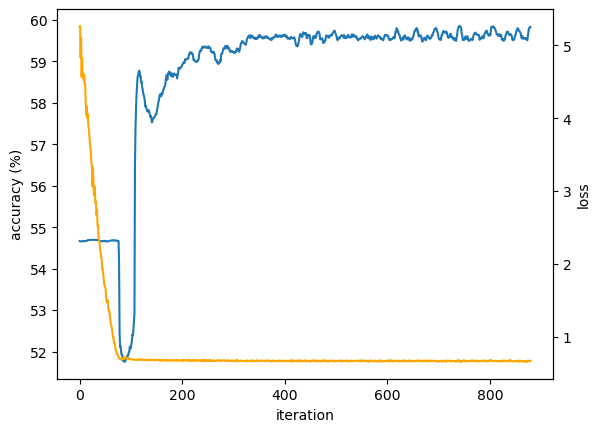

In [45]:
plt.plot(acc)
plt.xlabel('iteration')
plt.ylabel('accuracy (%)')
plt.twinx()
plt.plot(loss, color='orange')
plt.ylabel('loss')
plt.show()

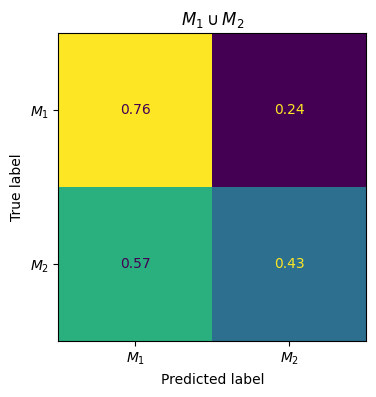

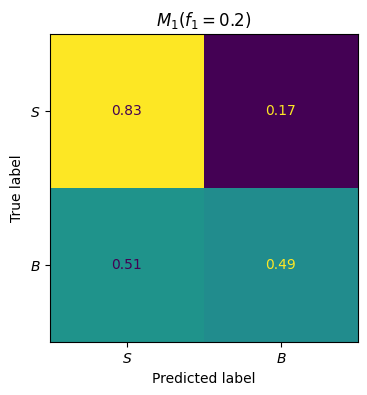

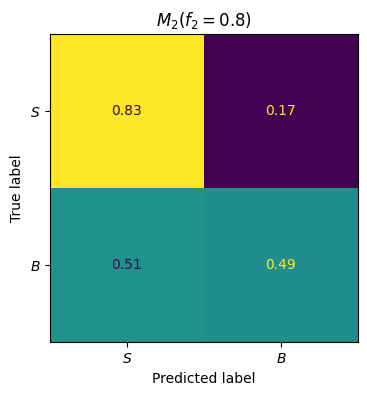

In [127]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(data, title='', **kwargs):
    # last column is the true label (note: data[:,1] = ~data[:,2))
    y_true = data[:,2]
    output = clf(torch.tensor(data[:,0], dtype=torch.float32, device='mps').unsqueeze(1))
    y_pred = torch.sigmoid(output).argmax(dim=1)

    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=100)
    ConfusionMatrixDisplay.from_predictions(
            y_true, y_pred.detach().cpu().numpy(), normalize='true', 
            cmap='viridis', colorbar=False, ax=ax,
            **kwargs
            )
    plt.title(title)
    plt.show()

plot_confusion_matrix(M1M2, '$M_1 \cup M_2$', display_labels=['$M_1$', '$M_2$'])
plot_confusion_matrix(M1, f'$M_1(f_1={f_1})$', display_labels=['$S$', '$B$'])
plot_confusion_matrix(M2, f'$M_2(f_2={f_2})$', display_labels=['$S$', '$B$'])